In [1]:
import numpy as np
import torch
from PQC import getHaar
import matplotlib.pyplot as plt
from QuantumState import *
from getPQCvector import *
from PQC_Loss import *

In [2]:
params = torch.zeros(84)
ParameterInitializer(params)
params.requires_grad_(True)
learning_rate = 0.002
losses = []
for i in range(1000):
    loss = Loss(params,verbose=0)
    loss.backward()
    losses.append(loss.item())
    print("epoch ",i+1,loss.item())
    with torch.no_grad():
        params -= learning_rate * params.grad
        params.grad.zero_()
plt.plot(losses)
Loss(params,verbose=1)

2083333
epoch  29 0.26911685765186283
epoch  30 0.18671329446434792
epoch  31 0.19531926270722444
epoch  32 0.21748425377337266
epoch  33 0.21572379799406935
epoch  34 0.2225074719148471
epoch  35 0.24579767821662887
epoch  36 0.18381360886979503
epoch  37 0.23260742187410566
epoch  38 0.22650993626193983
epoch  39 0.2037273056614911
epoch  40 0.26124069236805053
epoch  41 0.22640930325195732
epoch  42 0.205067972716499
epoch  43 0.20560065873378602
epoch  44 0.1942221479249415
epoch  45 0.23548649707964364
epoch  46 0.20536431990212423
epoch  47 0.20963348278855903
epoch  48 0.25017540334643973
epoch  49 0.26379860666136784
epoch  50 0.21119851791396552
epoch  51 0.13042328310728588
epoch  52 0.2070964535208498
epoch  53 0.20476415695362213
epoch  54 0.2328892148871501
epoch  55 0.2622705556153747
epoch  56 0.18007014925099826
epoch  57 0.18649381477289317
epoch  58 0.24509280365651567
epoch  59 0.16458079880432935
epoch  60 0.18350178051516405
epoch  61 0.18940840737093895
epoch  62 

KeyboardInterrupt: 

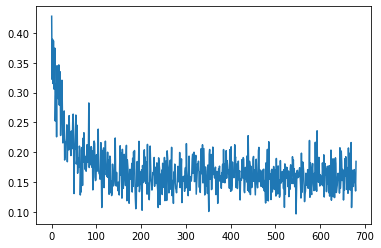

In [4]:
plt.plot(losses)


tensor(0.1070, dtype=torch.float64, grad_fn=<SumBackward0>)

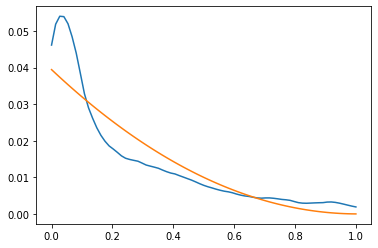

<Figure size 432x288 with 0 Axes>

In [5]:
Loss(params,verbose=1)

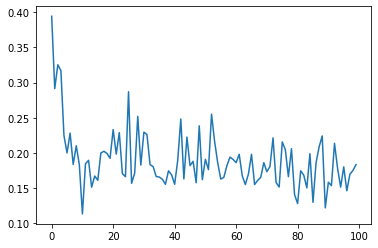

In [3]:
plt.plot(losses)

In [3]:
Fidelity = None
# print(Fidelity)
num = 10000
bins = 250
haar_hist = torch.from_numpy(getHaar(reps=num,bins=bins,qubits=2))
params = torch.randn(12,requires_grad=True)

for i in range(num):
    v1 = getPQCvector(params)
    v2 = getPQCvector(params)
    F = torch.abs(torch.matmul(torch.conj(torch.transpose(v1,0,1)),v2))**2
    if Fidelity is None:
        Fidelity = F.view(1,)
    else:
        Fidelity = torch.cat((Fidelity,F.view(1,)),-1)
hist = histbin(Fidelity)
hist2 = torch.histc(Fidelity,min=0,max=1,bins=bins)/num
# print("histbin",hist.detach())
# print("histc",hist2.detach())
# x = np.linspace(0,1,250)
# plt.plot(x,hist)
# plt.plot(x,hist2)

In [4]:
def Loss(params, verbose=0, bins=75, num=1000):
    Fidelity = None
    # print(Fidelity)
    haar_hist = torch.from_numpy(getHaar(reps=num,bins=bins,qubits=2))
    for i in range(num):
        v1 = getPQCvector(params)
        v2 = getPQCvector(params)
        F = torch.abs(torch.matmul(torch.conj(torch.transpose(v1,0,1)),v2))**2
        if Fidelity is None:
            Fidelity = F.view(1,)
        else:
            Fidelity = torch.cat((Fidelity,F.view(1,)),-1)
    print(Fidelity)
    hist = histbin(Fidelity)
    if verbose == 1:
        x = np.linspace(0,1,bins)
        plt.plot(x,torch.detach(hist))
        plt.plot(x,torch.detach(haar_hist))
        plt.figure()
    # kl = torch.kl_div(hist.log(),haar_hist,reduction=1)
    p = hist*(hist/haar_hist).log()
    p[p!=p]=0
    return p.sum()

In [7]:
m = torch.nn.Linear(2,2,bias=True)
m.requires_grad_(False)
input = torch.randn(1,2)
output = m(input)
print(output.size())
print(m.weight[0])
print(m.bias)
m.weight[0,0]=1

torch.Size([1, 2])
tensor([-0.5320, -0.2468])
Parameter containing:
tensor([ 0.3516, -0.6015])


In [34]:
# m.weight[0,0]=1
m = torch.nn.Linear(2,2,bias=True)
m.requires_grad_(False)

print(list(m.parameters()))

for p in m.parameters():
    print(p)
    print(p[0].weight)
print(list(m.parameters()))

[Parameter containing:
tensor([[-0.0934, -0.4060],
        [-0.5118, -0.1921]]), Parameter containing:
tensor([ 0.2878, -0.5292])]
Parameter containing:
tensor([[-0.0934, -0.4060],
        [-0.5118, -0.1921]])


AttributeError: 'Tensor' object has no attribute 'weight'

In [92]:
Layer1 = torch.nn.Linear(2,2)
Layer1.requires_grad_(False)
input = torch.rand(2,)
h1 = Layer1(input)
print(h1)
a=torch.nn.ReLU()(h1)
print(a.tolist()[1])

tensor([-0.5192,  0.6990])
0.6990397572517395


In [14]:
params = torch.randn(12,)
Layer1 = torch.nn.Linear(2,2)
Layer1.requires_grad_(False)
Layer1.weight[0] = params[:2]
Layer1.weight[1] = params[2:4]
print(Layer1)
print(Layer1.weight[0])
print(Layer1.bias[0])
print(params[4:6])
Layer1.bias = params[4:6]


Linear(in_features=2, out_features=2, bias=True)
tensor([0.3575, 2.8662])
tensor(0.1008)
tensor([0.3506, 1.5560])


TypeError: cannot assign 'torch.FloatTensor' as parameter 'bias' (torch.nn.Parameter or None expected)


th tensor([0.1796, 0.7775])
th tensor([0.5044, 0.2162])
th tensor([0.3826, 0.7761])
th tensor([0.3314, 0.8207])
th tensor([0.3934, 0.7126])
th tensor([0.2050, 0.8053])
th tensor([0.4576, 0.5231])
th tensor([0.5032, 0.2277])
th tensor([0.5026, 0.2299])
th tensor([0.4667, 0.4473])
th tensor([0.4453, 0.5951])
th tensor([0.4854, 0.3618])
th tensor([0.3119, 0.8170])
th tensor([0.3349, 0.7815])
th tensor([0.4827, 0.3403])
th tensor([0.4369, 0.5720])
th tensor([0.4882, 0.3319])
th tensor([0.2272, 0.8185])
th tensor([0.2345, 0.8227])
th tensor([0.5112, 0.1597])
th tensor([0.4947, 0.2718])
th tensor([0.3886, 0.7130])
th tensor([0.3612, 0.7548])
th tensor([0.4829, 0.3473])
th tensor([0.2978, 0.8189])
th tensor([0.5075, 0.1881])
th tensor([0.5012, 0.2369])
th tensor([0.4924, 0.3007])
th tensor([0.4852, 0.3515])
th tensor([0.4469, 0.5225])
th tensor([0.4836, 0.3709])
th tensor([0.4217, 0.6085])
th tensor([0.2051, 0.8038])
th tensor([0.4422, 0.5270])
th tensor([0.4468, 0.5586])
th tensor([0.4452, 

tensor(10.3246, dtype=torch.float64)

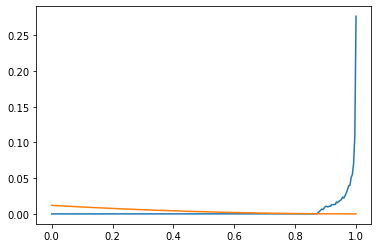

<Figure size 432x288 with 0 Axes>

In [5]:
params = torch.randn(12,)
print(params)
Loss(params,verbose=1)

In [10]:
eye = torch.eye(2)
one = torch.zeros(2,2)
zero = torch.zeros(2,2)
one[1,1]=1
zero[0,0]=1
print(one)
print(zero)

tensor([[0., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 0.]])
